In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

from PIL import Image, ImageOps

In [2]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_coronal_images_jpeg95')

In [3]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv')).set_index('UID')
bbox_df

,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.9940,1,139,148,339,2.666667,0.234375,0.625,0.0,259,297.23186,115.53983,85.18228,66.52623,140
1.2.826.0.1.3680043.9940,1,140,147,341,2.666667,0.234375,0.625,0.0,259,298.00000,117.00000,86.00000,61.00000,141
1.2.826.0.1.3680043.9940,1,141,148,341,2.666667,0.234375,0.625,0.0,259,298.00000,119.00000,87.00000,58.00000,142


In [4]:
df = pd.DataFrame()

def make_df(UID, intersect, start_index, end_index, xmin, xmax, aspect):
    # print(intersect)
    # print(start_index, end_index, y_min, ymax)
    new_df = pd.DataFrame()
    # print(len(intersect))
    print(intersect[len(intersect) // 2])
    new_df['sagittal_index'] = np.arange(intersect[len(intersect) // 2], intersect[len(intersect) // 2]+1)
    new_df[['UID','xmin','ymin','xmax','ymax']] = [UID, xmin, start_index * aspect, xmax, end_index * aspect]

    # print(new_df)
    return new_df

for UID in bbox_df.index.unique():
    # UID = '1.2.826.0.1.3680043.11300'
    patient_df = bbox_df.loc[UID].sort_values(by='axial_index')
    # print(patient_df)
    aspect = patient_df.iloc[0].aspect
    
    intersect_list = []

    intersect = np.arange(512)
    start_slice = None
    end_slice = None
    x_min = None
    x_max = None

    for i in range(len(patient_df)):
        s = patient_df.iloc[i]
        if i == 0:
            start_slice = s.axial_index
            x_min = s.x
            x_max = s.x + s.width

        if s.axial_index == (start_slice + i):
            y_array = np.arange(int(s.y), int(s.y + s.height))
            intersect = np.intersect1d(intersect, y_array)
            x_min = np.min((x_min, s.x))
            x_max = np.max((x_max, s.x + s.width))
            end_slice = s.axial_index
        else:
            # make_df(intersect, start_slice, end_slice, y_min, y_max)
            break
            # end previous box


            # reset
            intersect = np.arange(int(s.x), int(s.x + s.width))
            start_slice = s.axial_index
            y_min = s.y
            y_max = s.y + s.height
            end_slice = s.axial_index

    if len(intersect) > 0:
        new_df = make_df(UID, intersect, start_slice, end_slice, x_min, x_max, aspect)

        df = pd.concat((df, new_df))
# patient_df

234
261
270
131
234
362
180
115
269
252
171
237
110
144
109
209
190
243
241
252
288
179
129
184
234
233
248
228
183
213
130
203
73
259
219
344
174
280
156
173
251
220
203
182
163
182
205
158
204
104
271
267
233
131
173
191
264
262
267
182
219
243
157
360
291
235
332
277
313
211
267
263
257
258
199
259
176
107
200
138
276
214
160
121
207
240
118
152
245
301
224
139
239
251
208
117
254
238
166
190
185
263
162
137
143
212
296
179
172
211
214
165
273
228
262
135
274
230
275
283
315
89
180
104
166
279
237
170
181
192
295
191
222
230
278
228
377
211
272
180
273
191
200
127
144
77
170
313
178
168
179
229
281
246
175
167
203
294
365
203
294
106
324
176
191
206
245
186
284
166
198
190
148
240
219
199
211
395
178
270
301
98
247
96
168
147
319
192
209
299
218
195
137
160
190
179
146
110
179
204
194
193
159
202
65
224
202
172
212
238
157
199
285
158
298
208
148
148


In [5]:
df = df.set_index('UID')
df

,sagittal_index,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10051,234,191.22182,324.923397,252.66182,361.846510
1.2.826.0.1.3680043.10579,261,247.14625,234.666667,287.09549,240.761905
1.2.826.0.1.3680043.10678,270,117.41867,202.298851,189.14087,220.689655
1.2.826.0.1.3680043.10697,131,201.32881,467.153285,299.12891,493.313869
1.2.826.0.1.3680043.10732,234,133.31759,245.593496,371.93071,308.032520
...,...,...,...,...,...
1.2.826.0.1.3680043.8519,158,170.36460,128.503872,217.99769,141.102291
1.2.826.0.1.3680043.8693,298,149.17110,225.881572,287.00000,252.772236
1.2.826.0.1.3680043.9447,208,130.66163,167.437838,301.00567,211.718919


sagittal_index    130.000000
xmin              133.565220
ymin              227.555556
xmax              372.627600
ymax              259.555556
Name: 1.2.826.0.1.3680043.13360, dtype: float64


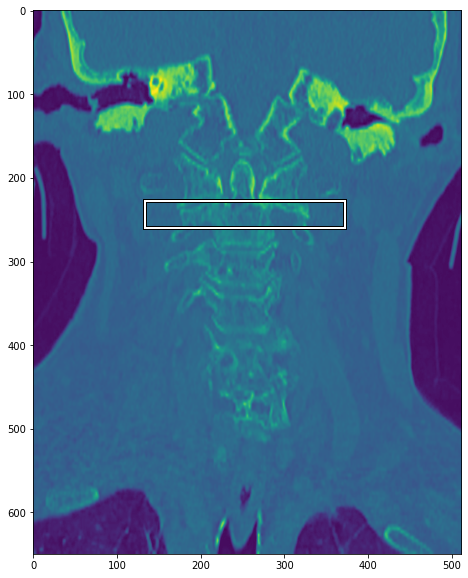

In [15]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()
    
    
s = df.iloc[30]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.name, f'{int(s.sagittal_index)}.jpeg'))
bbox = list(s[['xmin','ymin','xmax','ymax']])

# crop_box = s[['xmin','ymin','xmax','ymax']]
# image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

In [16]:
df.to_csv(os.path.join(DATA_DIR, 'coronal_bbox.csv'))